In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import Binarizer

In [3]:
# 모델 평가함수
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/aug_train.csv")

## 데이터 확인

In [5]:
# 결측치가 존재하지 않음
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


In [6]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


## 시각화

target값 분포 확인

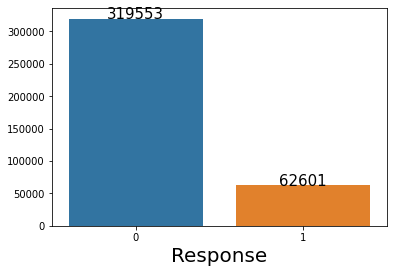

In [7]:
target = sns.countplot(x='Response', data=df)
target.set(ylabel=None)
target.set_xlabel("Response", fontsize = 20)
target.set_ylabel("", fontsize = 20)
for p in target.patches:
    height = p.get_height()
    target.text(p.get_x() + p.get_width() / 2., height + 5, height, ha = 'center', size = 15)

plt.show()

 -> 불균형 데이터임을 알 수 있습니다.

저희의 목표는 어떤 고객들이 보험에 더 관심을 갖는지를 알아보는것 입니다.   
그러므로 각 Feature당 Response 여부를 시각화하여, 추가적인 인사이트를 얻어보겠습니다.  
먼저 수치형 데이터부터 살펴보겠습니다. (0: 신청안함 1: 신청함)

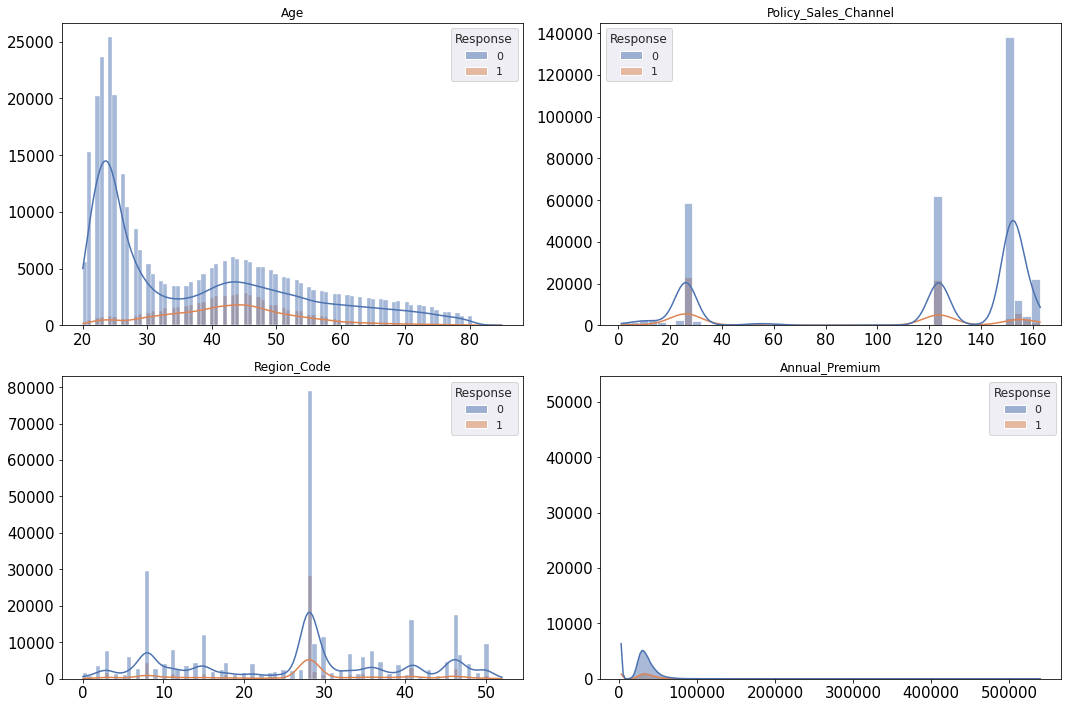

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.set(font_scale=1)
sns.histplot(x=df['Age'],kde=True,hue=df['Response'],ax=axes[0][0]).set(title='Age')
sns.histplot(x=df['Policy_Sales_Channel'],kde=True,hue=df['Response'],ax=axes[0][1]).set(title='Policy_Sales_Channel')
sns.histplot(x=df['Region_Code'],kde=True,hue=df['Response'],ax=axes[1][0]).set(title='Region_Code')
sns.histplot(x=df['Annual_Premium'],kde=True,hue=df['Response'],ax=axes[1][1]).set(title='Annual_Premium')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

**Age** : 20대가 가장 많이 집계되었지만, 신청횟수와 신청률은 저조했습니다.  
      반면, 30-40대는 20대에 비해 집계 수는 적지만, 신청횟수와 신청률이 압도적으로 높았습니다.    

**Policy_Sales_Channel** : 특정 채널들에서 압도적인 집계수를 확인할 수 있습니다.  
but, 150번 채널의 경우 다른 채널에 비해 신청률이 매우 저조함을 알 수 있습니다.

**Region_Code** : 특정 지역들에서 압도적인 집계수를 확인할 수 있고 28번 지역에서 높은 신청률을 보입니다.  

**Annual_Premium** : 이상치가 존재하여 오른쪽으로 긴 꼬리를 형성하고 있습니다.

다음으로는 범주형 데이터의 Response 여부를 확인해 보겠습니다.

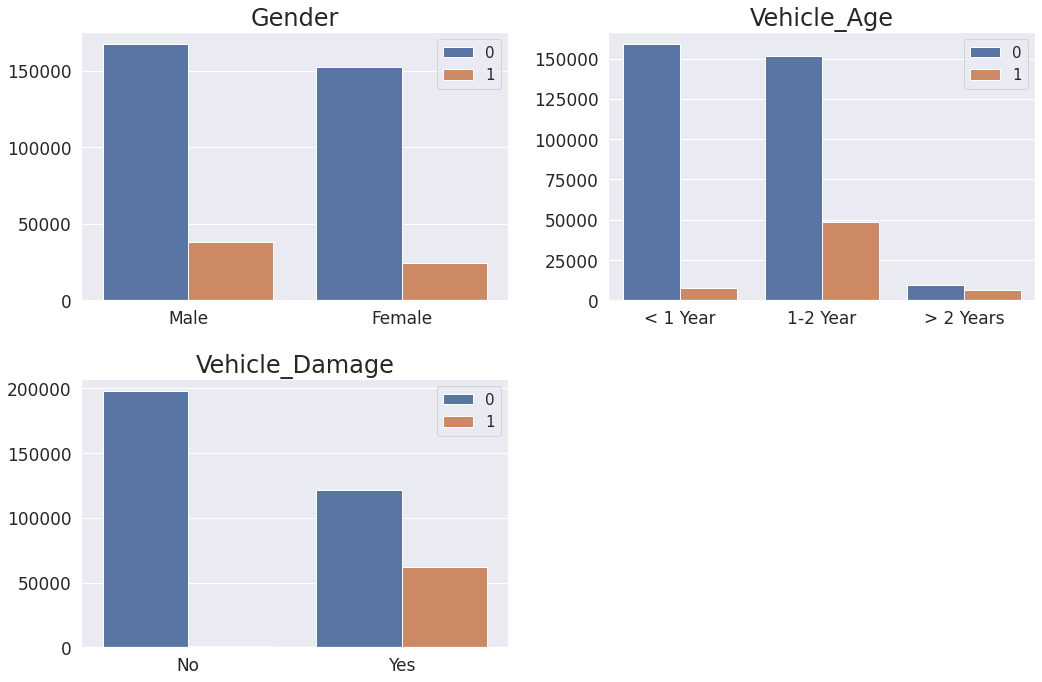

In [9]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

sns.set(font_scale=2)
sns.countplot(x='Gender',hue=df['Response'], data=df, ax=axes[0][0]).set(title='Gender')
sns.countplot(x='Vehicle_Age',hue=df['Response'], data=df, ax=axes[0][1]).set(title='Vehicle_Age')
sns.countplot(x='Vehicle_Damage',hue=df['Response'], data=df, ax=axes[1][0]).set(title='Vehicle_Damage')


for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=17)
        axes[i][j].legend(loc='upper right',fontsize='15')

fig.delaxes(axes[1][1])
plt.tight_layout()
plt.show()

Vehicle_Age : 차량의 나이가 많을수록 신청률이 높아짐을 알 수 있음.

Vehicle_Damage : 차량 손상이 있을 경우 신청률이 압도적으로 높음을 알 수 있음.

### 상관관계

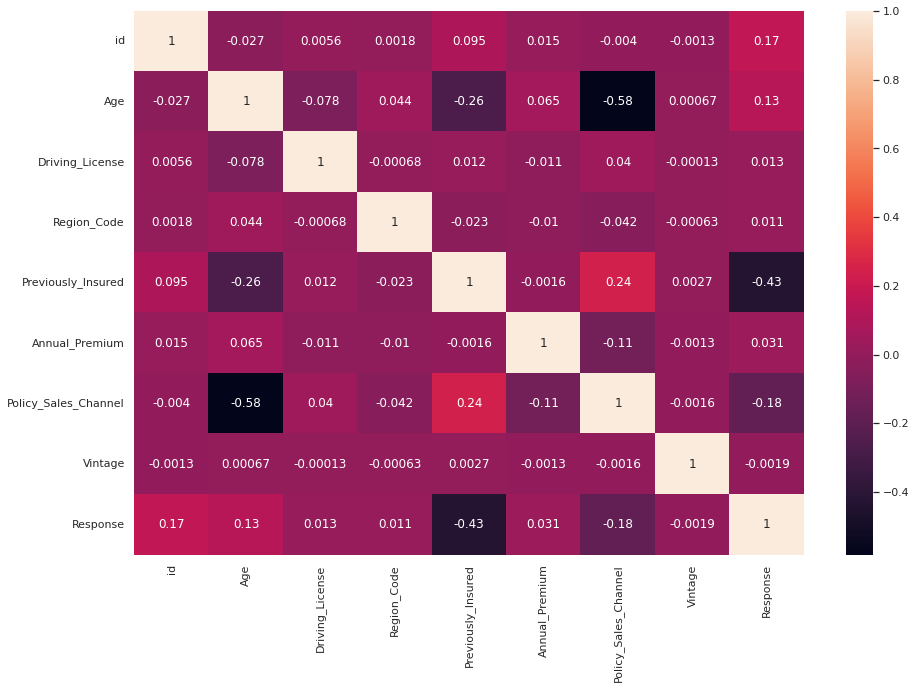

In [10]:
sns.set(font_scale=1)
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

target과의 관계 : Vehicle_Damage칼럼의 경우 0.45의 유의미한 상관관계를 띄고 있음  
Previously_Insured칼럼 역시 -0.43의 유의미한 상관관계를 띄고 있음  
나머지 칼럼들은 크게 유의미한 상관관계를 찾을 수 없음

독립변수들간의 관계 : Vehicle_Damage와 Previously_Insured는 -0.85의 높은 상관관계를 보임
다중공선성을 의심할 수 있음

## 결측치 확인

In [11]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i,col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col +=1
            print('결측치가 있는 칼럼은: %s입니다.'%col)
            print('해당 칼럼에 총 %s개의 결측치가 존재합니다. '%missing_values)
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다.')
    return missing_col

missing_col = check_missing_col(df)

결측치가 존재하지 않습니다.


## 불필요한 변수 삭제

In [12]:
df.drop(['id'], axis=1, inplace=True)

## 이상치 처리

boxplot 확인

[Text(0.5, 1.0, 'Annual_Premium')]

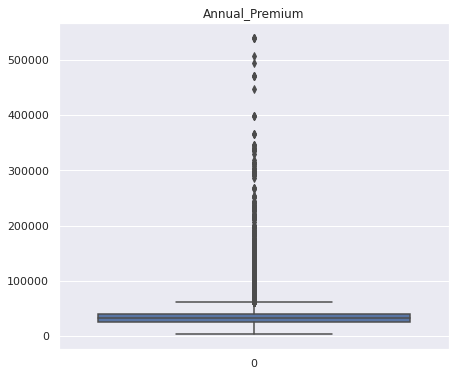

In [13]:
plt.figure(figsize=(7,6))
sns.boxplot(data=df['Annual_Premium']).set(title = 'Annual_Premium')

[Text(0.5, 1.0, 'Age')]

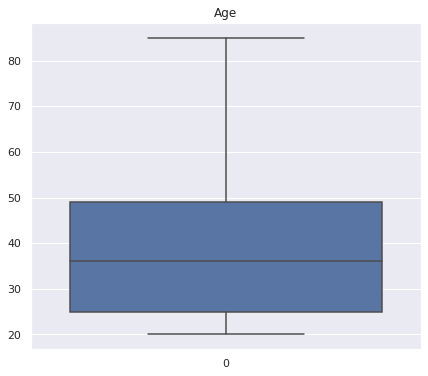

In [14]:
plt.figure(figsize=(7,6))
sns.boxplot(data=df['Age']).set(title = 'Age')

[Text(0.5, 1.0, 'Vintage')]

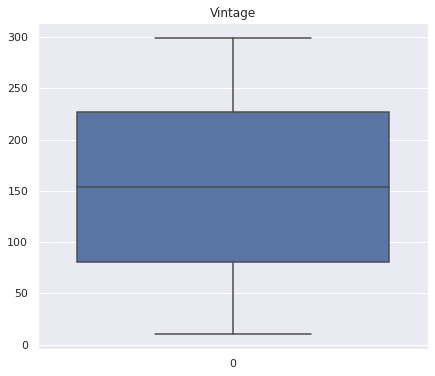

In [15]:
plt.figure(figsize=(7,6))
sns.boxplot(data=df['Vintage']).set(title = 'Vintage')

Annual_Premium 분포 확인

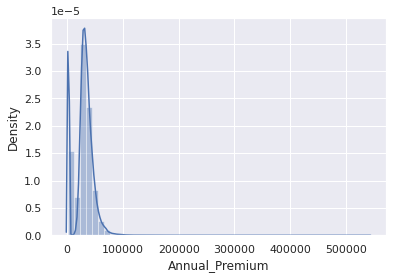

In [16]:
sns.distplot(df['Annual_Premium'])

In [17]:
# 이상치들 상한값, 하한값으로 대체
def outlier(df):
    IQR = df.quantile(0.75) - df.quantile(0.25)
    line_down = df.quantile(0.25) - IQR*1.5
    line_up = df.quantile(0.75) + IQR*1.5

    df = df.clip(line_down, line_up)

    return df

df['Annual_Premium'] = outlier(df['Annual_Premium'])

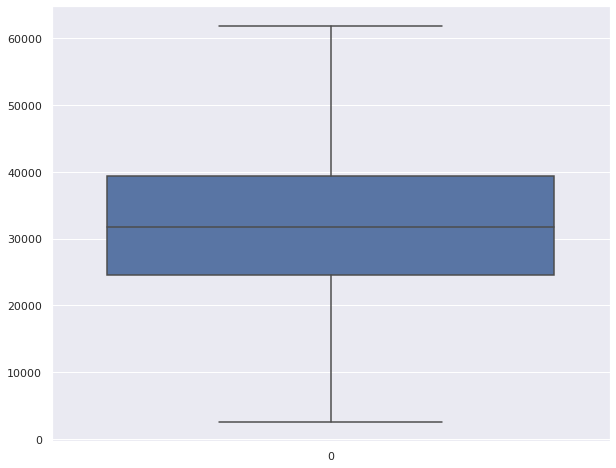

In [18]:
# 이상치 처리 후 boxplot 확인
plt.figure(figsize=(10,8))
sns.boxplot(data=df['Annual_Premium'])

## Age를 범주화하여 Age_level 생성

모든 기준은 대한민국 평균 연령로 결정하였습니다.  
1) 평균 취업 연령 : 28세  
2) 평균 결혼 및 출산 연령 : 32세  
3) 평균 내 집 마련 연령 : 40세  
4) 평균 은퇴 연령 : 60세   
를 이용해 Age를 범주화하여 'Age_level' 칼럼을 새로 생성하였습니다.

In [19]:
condition1 = (df['Age'] < 28)
condition2 = (df['Age'] >= 28) & (df['Age'] < 32)
condition3 = (df['Age'] >= 32) & (df['Age'] < 40)
condition4 = (df['Age'] >= 40) & (df['Age'] < 60)
condition5 = (df['Age'] >= 60)

In [20]:
df['Age_level'] = np.where(condition1, 0, np.where(condition2,1,np.where(condition3,2,np.where(condition4,3,np.where(condition5,4,"NaN")))))

In [21]:
df['Age_level'] = pd.to_numeric(df['Age_level'])

In [22]:
df.drop(['Age'],axis= 1, inplace=True)

## Encoding

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
# 범주형 변수들 LabelEnoding
features = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']

In [25]:
for o_col in features:
    encoder = LabelEncoder()
    encoder.fit(df[o_col])
    df[o_col] = encoder.transform(df[o_col])

## Scaling

In [26]:
# 로그변환
df['Annual_Premium'] = np.log1p(df['Annual_Premium'])

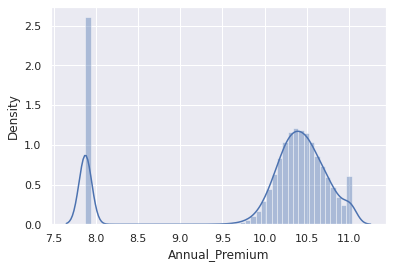

In [27]:
sns.distplot(df['Annual_Premium'])

## train_test_split

In [28]:
X = df.drop(['Response','Vintage'],axis= 1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

## OverSampling

In [29]:
from imblearn.over_sampling import ADASYN

In [30]:
adasyn = ADASYN(random_state= 42)
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train_over, y_train_over)
lgr_pred = lgr.predict(X_test)
get_clf_eval(y_test ,lgr_pred)

오차 행렬
[[41032 22757]
 [  172 12470]]
정확도: 0.7000, 정밀도: 0.3540, 재현율: 0.9864,    F1: 0.5210, AUC:0.8148


In [33]:
pred_proba = lgr.predict_proba(X_test)

# Binarizer의 threshold 값을 0.65로 설정
custom_threshold = 0.65

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# Vintage 제거 전
# 정확도: 0.7309, 정밀도: 0.3625, 재현율: 0.8264,    F1: 0.5040, AUC:0.7692

# Vintage 제거 후
# 정확도: 0.7642, 정밀도: 0.4041, 재현율: 0.8960,    F1: 0.5570, AUC:0.8170

오차 행렬
[[47083 16706]
 [ 1315 11327]]
정확도: 0.7642, 정밀도: 0.4041, 재현율: 0.8960,    F1: 0.5570, AUC:0.8170


## RandomForest

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
pred_proba = rf.predict_proba(X_test)

# Binarizer의 threshold 값을 0.1로 설정
custom_threshold = 0.1
# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 정확도: 0.7719, 정밀도: 0.4055, 재현율: 0.8142,    F1: 0.5414, AUC:0.7888

오차 행렬
[[48701 15088]
 [ 2349 10293]]
정확도: 0.7719, 정밀도: 0.4055, 재현율: 0.8142,    F1: 0.5414, AUC:0.7888


## LightGBM

In [36]:
from lightgbm import LGBMClassifier

In [37]:
lgbm = LGBMClassifier(n_estimators =3042, min_child_weight = 2, max_depth = 14, learning_rate = 0.06, random_state= 42, class_weight = 'balanced')

lgbm.fit(X_train, y_train)


LGBMClassifier(class_weight='balanced', learning_rate=0.06, max_depth=14,
               min_child_weight=2, n_estimators=3042, random_state=42)

LGBM threshold 변경

In [38]:
pred_proba = lgbm.predict_proba(X_test)

# Binarizer의 threshold 값을 0.67로 설정
custom_threshold = 0.67

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 정확도: 0.8214, 정밀도: 0.4764, 재현율: 0.8039,    F1: 0.5983, AUC:0.8144

오차 행렬
[[52620 11169]
 [ 2479 10163]]
정확도: 0.8214, 정밀도: 0.4764, 재현율: 0.8039,    F1: 0.5983, AUC:0.8144


LGBM 파라미터 튜닝

In [39]:
def LGBM_cv(max_depth,learning_rate, n_estimators
             ,min_child_weight, silent=True):

      # 모델 정의
    model = LGBMClassifier(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                min_child_weight=int(min_child_weight)
                                # class_weights = class_weights
                                )
      # 모델 훈련
    model.fit(X_train, y_train)

      # 예측값 출력
    y_pred= model.predict(X_test)

      # metric 계산
    f1 = f1_score(y_test,y_pred)
      # 오차 최적화로 사용할 metric 반환
    return f1

In [ ]:
!pip install bayesian-optimization

In [43]:
from bayes_opt import BayesianOptimization
import numpy as np

  # 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 15),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (100, 5000),
                'min_child_weight': (0, 10)
                            }


  # Bayesian optimization 객체 생성
  # f : 탐색 대상 함수, pbounds : hyperparameter 집합
  # verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
  # random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=LGBM_cv, pbounds=pbounds, verbose=1, random_state=42)    

  # 메소드를 이용해 최대화 과정 수행
  # init_points :  초기 Random Search 갯수
  # n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
  # acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
  # xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

  # ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
  # 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
  # bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

  # 찾은 파라미터 값 확인
print(bo.max) 


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
|  3        |  0.4453   |  0.06399  |  12.4     |  6.71     |  3.03e+03 |
|  8        |  0.4478   |  0.1883   |  11.48    |  4.501    |  4.992e+0 |
|  11       |  0.4489   |  0.0112   |  8.511    |  9.767    |  2.681e+0 |
{'target': 0.4489454613026108, 'params': {'learning_rate': 0.01119769267873879, 'max_depth': 8.511438078423566, 'min_child_weight': 9.766598130704375, 'n_estimators': 2681.067576339777}}


## CatBoost

In [44]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [45]:
from catboost import CatBoostClassifier

In [46]:
from sklearn.utils.class_weight import compute_class_weight

# 불균형한 클래스인 것으로 확인되어 class_weight = 'balanced'로 설정해준다. 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [47]:
cb = CatBoostClassifier(random_state=42, class_weights= class_weights, verbose = 0)

In [48]:
#모델 학습
cb.fit(X_train, y_train)

cb_pred = cb.predict(X_test)

In [49]:
get_clf_eval(y_test, cb_pred)

오차 행렬
[[48231 15558]
 [ 1052 11590]]
정확도: 0.7827, 정밀도: 0.4269, 재현율: 0.9168,    F1: 0.5826, AUC:0.8364


catboost 하이퍼파라미터 튜닝

In [50]:
# !pip install bayesian-optimization

In [51]:
## CatBoost Hyperparameter 튜닝 

def CB_cv(max_depth,learning_rate, n_estimators, subsample
             ,colsample_bylevel,bagging_temperature,l2_leaf_reg,min_child_samples, silent=True):

      # 모델 정의
      model = CatBoostClassifier(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                subsample=subsample,
                                colsample_bylevel=colsample_bylevel,
                                bagging_temperature = bagging_temperature,
                                l2_leaf_reg = l2_leaf_reg,
                                min_child_samples = min_child_samples
                          
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)

      # metric 계산
      f1 = f1_score(y_test,y_pred)
      # 오차 최적화로 사용할 metric 반환
      return f1

In [52]:
from bayes_opt import BayesianOptimization
import numpy as np

# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 16),
                'learning_rate': (0.01, 0.3),
           'bagging_temperature' :(0.01, 100.00),
                'n_estimators': (1000, 6000),
           "l2_leaf_reg" : (1e-8,3e-5),
                'subsample': (0.5, 1),
           "min_child_samples": (5, 100),
                'colsample_bylevel' :(0.2, 1)
                }


# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=CB_cv, pbounds=pbounds, verbose= 0, random_state=42)    

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=20, acq='ei', xi=0.01)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냄

# 찾은 파라미터 값 확인
print(bo.max)

0:	learn: 0.4266033	total: 40.5ms	remaining: 52.2s
1:	learn: 0.3431944	total: 77ms	remaining: 49.6s
2:	learn: 0.3137779	total: 110ms	remaining: 47.3s
3:	learn: 0.3010054	total: 148ms	remaining: 47.6s
4:	learn: 0.2953141	total: 185ms	remaining: 47.5s
5:	learn: 0.2912687	total: 227ms	remaining: 48.6s
6:	learn: 0.2889175	total: 265ms	remaining: 48.6s
7:	learn: 0.2875712	total: 298ms	remaining: 47.7s
8:	learn: 0.2856792	total: 325ms	remaining: 46.2s
9:	learn: 0.2846000	total: 357ms	remaining: 45.8s
10:	learn: 0.2839258	total: 390ms	remaining: 45.3s
11:	learn: 0.2832374	total: 426ms	remaining: 45.4s
12:	learn: 0.2824282	total: 452ms	remaining: 44.4s
13:	learn: 0.2820323	total: 479ms	remaining: 43.7s
14:	learn: 0.2814412	total: 510ms	remaining: 43.3s
15:	learn: 0.2810934	total: 544ms	remaining: 43.3s
16:	learn: 0.2808352	total: 585ms	remaining: 43.8s
17:	learn: 0.2805840	total: 620ms	remaining: 43.8s
18:	learn: 0.2802789	total: 661ms	remaining: 44.2s
19:	learn: 0.2799264	total: 693ms	remaini

Training has stopped (degenerate solution on iteration 10, probably too small l2-regularization, try to increase it)


0:	learn: 0.6498389	total: 22ms	remaining: 28.4s
1:	learn: 0.5487628	total: 70.1ms	remaining: 45.2s
2:	learn: 0.4707787	total: 259ms	remaining: 1m 51s
3:	learn: 0.4288770	total: 283ms	remaining: 1m 30s
4:	learn: 0.3952036	total: 306ms	remaining: 1m 18s
5:	learn: 0.3747423	total: 344ms	remaining: 1m 13s
6:	learn: 0.3558796	total: 373ms	remaining: 1m 8s
7:	learn: 0.3423170	total: 419ms	remaining: 1m 7s
8:	learn: 0.3323868	total: 453ms	remaining: 1m 4s
9:	learn: 0.3220209	total: 616ms	remaining: 1m 18s
10:	learn: 0.3144953	total: 667ms	remaining: 1m 17s
11:	learn: 0.3092822	total: 700ms	remaining: 1m 14s
12:	learn: 0.3066981	total: 723ms	remaining: 1m 11s
13:	learn: 0.3021322	total: 885ms	remaining: 1m 20s
14:	learn: 0.2990023	total: 925ms	remaining: 1m 18s
15:	learn: 0.2968259	total: 956ms	remaining: 1m 16s
16:	learn: 0.2941146	total: 1.02s	remaining: 1m 16s
17:	learn: 0.2920739	total: 1.1s	remaining: 1m 17s
18:	learn: 0.2912714	total: 1.13s	remaining: 1m 15s
19:	learn: 0.2896881	total: 

Training has stopped (degenerate solution on iteration 46, probably too small l2-regularization, try to increase it)


0:	learn: 0.6213863	total: 203ms	remaining: 14m 16s
1:	learn: 0.5659280	total: 236ms	remaining: 8m 18s
2:	learn: 0.5202560	total: 265ms	remaining: 6m 11s
3:	learn: 0.4775658	total: 618ms	remaining: 10m 50s
4:	learn: 0.4419259	total: 960ms	remaining: 13m 28s
5:	learn: 0.4180034	total: 988ms	remaining: 11m 33s
6:	learn: 0.3953997	total: 1.36s	remaining: 13m 35s
7:	learn: 0.3772916	total: 1.63s	remaining: 14m 18s
8:	learn: 0.3633882	total: 1.92s	remaining: 14m 57s
9:	learn: 0.3502055	total: 2.25s	remaining: 15m 48s
10:	learn: 0.3403175	total: 2.62s	remaining: 16m 39s
11:	learn: 0.3308997	total: 2.94s	remaining: 17m 11s
12:	learn: 0.3249025	total: 3.04s	remaining: 16m 23s
13:	learn: 0.3190231	total: 3.41s	remaining: 17m 2s
14:	learn: 0.3140571	total: 3.75s	remaining: 17m 31s
15:	learn: 0.3099955	total: 4.13s	remaining: 18m 4s
16:	learn: 0.3063850	total: 4.49s	remaining: 18m 28s
17:	learn: 0.3036084	total: 4.83s	remaining: 18m 47s
18:	learn: 0.3014572	total: 4.87s	remaining: 17m 56s
19:	lea

Training has stopped (degenerate solution on iteration 85, probably too small l2-regularization, try to increase it)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2471:	learn: 0.2749647	total: 1m 2s	remaining: 1m 26s
2472:	learn: 0.2749642	total: 1m 2s	remaining: 1m 26s
2473:	learn: 0.2749641	total: 1m 2s	remaining: 1m 26s
2474:	learn: 0.2749638	total: 1m 2s	remaining: 1m 26s
2475:	learn: 0.2749619	total: 1m 3s	remaining: 1m 26s
2476:	learn: 0.2749605	total: 1m 3s	remaining: 1m 25s
2477:	learn: 0.2749597	total: 1m 3s	remaining: 1m 25s
2478:	learn: 0.2749585	total: 1m 3s	remaining: 1m 25s
2479:	learn: 0.2749573	total: 1m 3s	remaining: 1m 25s
2480:	learn: 0.2749550	total: 1m 3s	remaining: 1m 25s
2481:	learn: 0.2749537	total: 1m 3s	remaining: 1m 25s
2482:	learn: 0.2749530	total: 1m 3s	remaining: 1m 25s
2483:	learn: 0.2749528	total: 1m 3s	remaining: 1m 25s
2484:	learn: 0.2749524	total: 1m 3s	remaining: 1m 25s
2485:	learn: 0.2749514	total: 1m 3s	remaining: 1m 25s
2486:	learn: 0.2749504	total: 1m 3s	remaining: 1m 25s
2487:	learn: 0.2749501	total: 1m 3s	remaining: 1m 25s
2488:	learn: 0.2749495	total: 1m 3s	remaining:

Training has stopped (degenerate solution on iteration 1615, probably too small l2-regularization, try to increase it)


0:	learn: 0.5747075	total: 202ms	remaining: 14m 19s
1:	learn: 0.4913062	total: 737ms	remaining: 26m 7s
2:	learn: 0.4333433	total: 1.29s	remaining: 30m 35s
3:	learn: 0.3937327	total: 1.48s	remaining: 26m 15s
4:	learn: 0.3648784	total: 2.04s	remaining: 28m 59s
5:	learn: 0.3455248	total: 2.61s	remaining: 30m 51s
6:	learn: 0.3324600	total: 2.71s	remaining: 27m 28s
7:	learn: 0.3220169	total: 3.13s	remaining: 27m 44s
8:	learn: 0.3138640	total: 3.58s	remaining: 28m 11s
9:	learn: 0.3074196	total: 4.04s	remaining: 28m 36s
10:	learn: 0.3034905	total: 4.07s	remaining: 26m 12s
11:	learn: 0.2998531	total: 4.15s	remaining: 24m 27s
12:	learn: 0.2964449	total: 4.56s	remaining: 24m 49s
13:	learn: 0.2936171	total: 4.75s	remaining: 23m 59s
14:	learn: 0.2912891	total: 4.85s	remaining: 22m 52s
15:	learn: 0.2893417	total: 5.19s	remaining: 22m 55s
16:	learn: 0.2876151	total: 5.5s	remaining: 22m 53s
17:	learn: 0.2862313	total: 5.82s	remaining: 22m 51s
18:	learn: 0.2854076	total: 5.85s	remaining: 21m 46s
19:	l

Training has stopped (degenerate solution on iteration 37, probably too small l2-regularization, try to increase it)


0:	learn: 0.3998219	total: 44.6ms	remaining: 3m 29s
1:	learn: 0.3205117	total: 607ms	remaining: 23m 44s
2:	learn: 0.3013017	total: 632ms	remaining: 16m 28s
3:	learn: 0.2890870	total: 1.22s	remaining: 23m 52s
4:	learn: 0.2840700	total: 1.52s	remaining: 23m 46s
5:	learn: 0.2809471	total: 2.15s	remaining: 28m
6:	learn: 0.2789078	total: 2.76s	remaining: 30m 46s
7:	learn: 0.2785714	total: 2.78s	remaining: 27m 7s
8:	learn: 0.2776550	total: 3.45s	remaining: 29m 57s
9:	learn: 0.2772630	total: 3.49s	remaining: 27m 13s
10:	learn: 0.2839124	total: 3.83s	remaining: 27m 12s


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)


0:	learn: 0.5978208	total: 46ms	remaining: 1m 13s
1:	learn: 0.5241818	total: 92.6ms	remaining: 1m 13s
2:	learn: 0.4694739	total: 141ms	remaining: 1m 14s
3:	learn: 0.4279438	total: 187ms	remaining: 1m 14s
4:	learn: 0.3974852	total: 233ms	remaining: 1m 14s
5:	learn: 0.3744772	total: 283ms	remaining: 1m 14s
6:	learn: 0.3571431	total: 328ms	remaining: 1m 14s
7:	learn: 0.3434293	total: 377ms	remaining: 1m 14s
8:	learn: 0.3330087	total: 424ms	remaining: 1m 14s
9:	learn: 0.3249895	total: 470ms	remaining: 1m 14s
10:	learn: 0.3182120	total: 518ms	remaining: 1m 14s
11:	learn: 0.3130271	total: 560ms	remaining: 1m 13s
12:	learn: 0.3087822	total: 601ms	remaining: 1m 13s
13:	learn: 0.3050666	total: 643ms	remaining: 1m 12s
14:	learn: 0.3021824	total: 685ms	remaining: 1m 12s
15:	learn: 0.2997065	total: 736ms	remaining: 1m 12s
16:	learn: 0.2975893	total: 770ms	remaining: 1m 11s
17:	learn: 0.2958104	total: 812ms	remaining: 1m 11s
18:	learn: 0.2942581	total: 857ms	remaining: 1m 11s
19:	learn: 0.2928767	t

Training has stopped (degenerate solution on iteration 289, probably too small l2-regularization, try to increase it)


0:	learn: 0.3950795	total: 39.1ms	remaining: 2m 51s
1:	learn: 0.3165900	total: 481ms	remaining: 17m 34s
2:	learn: 0.2953217	total: 948ms	remaining: 23m 3s
3:	learn: 0.2880154	total: 1.01s	remaining: 18m 22s
4:	learn: 0.2829982	total: 1.62s	remaining: 23m 39s
5:	learn: 0.2803838	total: 1.85s	remaining: 22m 29s
6:	learn: 0.2784499	total: 2.47s	remaining: 25m 46s
7:	learn: 0.2773980	total: 3.13s	remaining: 28m 30s
8:	learn: 0.2762361	total: 3.42s	remaining: 27m 44s
9:	learn: 0.2752100	total: 4s	remaining: 29m 8s
10:	learn: 0.2746501	total: 4.55s	remaining: 30m 10s
11:	learn: 0.2742671	total: 4.77s	remaining: 28m 57s
12:	learn: 0.2737798	total: 5.29s	remaining: 29m 37s
13:	learn: 0.2731841	total: 5.61s	remaining: 29m 11s
14:	learn: 0.2730162	total: 6.14s	remaining: 29m 48s
15:	learn: 0.2727332	total: 6.73s	remaining: 30m 36s
16:	learn: 0.2723968	total: 7.02s	remaining: 30m 2s
17:	learn: 0.2719808	total: 7.62s	remaining: 30m 46s
18:	learn: 0.2716600	total: 8.21s	remaining: 31m 24s
19:	learn

Training has stopped (degenerate solution on iteration 57, probably too small l2-regularization, try to increase it)


0:	learn: 0.4939200	total: 33.9ms	remaining: 1m 55s
1:	learn: 0.3711339	total: 73.4ms	remaining: 2m 5s
2:	learn: 0.3257861	total: 111ms	remaining: 2m 6s
3:	learn: 0.3070777	total: 149ms	remaining: 2m 7s
4:	learn: 0.2978719	total: 186ms	remaining: 2m 7s
5:	learn: 0.2925003	total: 224ms	remaining: 2m 7s
6:	learn: 0.2892590	total: 264ms	remaining: 2m 8s
7:	learn: 0.2871925	total: 301ms	remaining: 2m 8s
8:	learn: 0.2859069	total: 341ms	remaining: 2m 9s
9:	learn: 0.2846634	total: 379ms	remaining: 2m 9s
10:	learn: 0.2836592	total: 413ms	remaining: 2m 7s
11:	learn: 0.2830571	total: 450ms	remaining: 2m 7s
12:	learn: 0.2823306	total: 490ms	remaining: 2m 8s
13:	learn: 0.2815412	total: 527ms	remaining: 2m 8s
14:	learn: 0.2808345	total: 559ms	remaining: 2m 6s
15:	learn: 0.2804654	total: 595ms	remaining: 2m 6s
16:	learn: 0.2800026	total: 628ms	remaining: 2m 5s
17:	learn: 0.2797506	total: 663ms	remaining: 2m 5s
18:	learn: 0.2794693	total: 700ms	remaining: 2m 5s
19:	learn: 0.2792313	total: 739ms	rema

Training has stopped (degenerate solution on iteration 71, probably too small l2-regularization, try to increase it)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3474:	learn: 0.2731478	total: 1m 26s	remaining: 59.5s
3475:	learn: 0.2731463	total: 1m 26s	remaining: 59.5s
3476:	learn: 0.2731460	total: 1m 26s	remaining: 59.5s
3477:	learn: 0.2731448	total: 1m 26s	remaining: 59.4s
3478:	learn: 0.2731441	total: 1m 26s	remaining: 59.4s
3479:	learn: 0.2731439	total: 1m 26s	remaining: 59.4s
3480:	learn: 0.2731436	total: 1m 26s	remaining: 59.4s
3481:	learn: 0.2731429	total: 1m 27s	remaining: 59.3s
3482:	learn: 0.2731428	total: 1m 27s	remaining: 59.3s
3483:	learn: 0.2731425	total: 1m 27s	remaining: 59.3s
3484:	learn: 0.2731421	total: 1m 27s	remaining: 59.3s
3485:	learn: 0.2731418	total: 1m 27s	remaining: 59.2s
3486:	learn: 0.2731415	total: 1m 27s	remaining: 59.2s
3487:	learn: 0.2731406	total: 1m 27s	remaining: 59.2s
3488:	learn: 0.2731406	total: 1m 27s	remaining: 59.2s
3489:	learn: 0.2731398	total: 1m 27s	remaining: 59.1s
3490:	learn: 0.2731389	total: 1m 27s	remaining: 59.1s
3491:	learn: 0.2731388	total: 1m 27s	remaining

Training has stopped (degenerate solution on iteration 2617, probably too small l2-regularization, try to increase it)


0:	learn: 0.4312592	total: 49.4ms	remaining: 2m 25s
1:	learn: 0.3439298	total: 94.6ms	remaining: 2m 19s
2:	learn: 0.3124956	total: 141ms	remaining: 2m 18s
3:	learn: 0.2996448	total: 190ms	remaining: 2m 19s
4:	learn: 0.2934454	total: 237ms	remaining: 2m 19s
5:	learn: 0.2889670	total: 286ms	remaining: 2m 19s
6:	learn: 0.2859852	total: 332ms	remaining: 2m 19s
7:	learn: 0.2855768	total: 365ms	remaining: 2m 14s
8:	learn: 0.2843637	total: 402ms	remaining: 2m 11s
9:	learn: 0.2835727	total: 455ms	remaining: 2m 13s
10:	learn: 0.2827032	total: 498ms	remaining: 2m 12s
11:	learn: 0.2822204	total: 536ms	remaining: 2m 11s
12:	learn: 0.2816975	total: 582ms	remaining: 2m 11s
13:	learn: 0.2820711	total: 619ms	remaining: 2m 9s
14:	learn: 0.2817855	total: 666ms	remaining: 2m 10s
15:	learn: 0.5696195	total: 711ms	remaining: 2m 10s


Training has stopped (degenerate solution on iteration 16, probably too small l2-regularization, try to increase it)


0:	learn: 0.4790051	total: 32.5ms	remaining: 1m 35s
1:	learn: 0.3835094	total: 66.7ms	remaining: 1m 37s
2:	learn: 0.3405004	total: 98.9ms	remaining: 1m 36s
3:	learn: 0.3190110	total: 132ms	remaining: 1m 36s
4:	learn: 0.3074006	total: 162ms	remaining: 1m 34s
5:	learn: 0.3010342	total: 193ms	remaining: 1m 34s
6:	learn: 0.2962595	total: 221ms	remaining: 1m 32s
7:	learn: 0.2927909	total: 257ms	remaining: 1m 34s
8:	learn: 0.2905998	total: 291ms	remaining: 1m 34s
9:	learn: 0.2891537	total: 327ms	remaining: 1m 35s
10:	learn: 0.2877257	total: 360ms	remaining: 1m 35s
11:	learn: 0.2868001	total: 385ms	remaining: 1m 33s
12:	learn: 0.2861797	total: 415ms	remaining: 1m 33s
13:	learn: 0.2856430	total: 449ms	remaining: 1m 33s
14:	learn: 0.2851687	total: 486ms	remaining: 1m 34s
15:	learn: 0.2849798	total: 522ms	remaining: 1m 35s
16:	learn: 0.2845002	total: 552ms	remaining: 1m 34s
17:	learn: 0.2838690	total: 582ms	remaining: 1m 34s
18:	learn: 0.2831322	total: 616ms	remaining: 1m 34s
19:	learn: 0.282819

Training has stopped (degenerate solution on iteration 2511, probably too small l2-regularization, try to increase it)


0:	learn: 0.3524191	total: 77.3ms	remaining: 5m 38s
1:	learn: 0.3006648	total: 254ms	remaining: 9m 17s
2:	learn: 0.2873151	total: 428ms	remaining: 10m 25s
3:	learn: 0.2826659	total: 503ms	remaining: 9m 10s
4:	learn: 0.2991906	total: 602ms	remaining: 8m 46s
5:	learn: 0.2977782	total: 701ms	remaining: 8m 31s
6:	learn: 0.3107124	total: 801ms	remaining: 8m 20s
7:	learn: 0.3189216	total: 905ms	remaining: 8m 15s
8:	learn: 0.3199514	total: 999ms	remaining: 8m 5s
9:	learn: 0.3196535	total: 1.12s	remaining: 8m 9s
10:	learn: 0.3190534	total: 1.21s	remaining: 8m


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)


0:	learn: 0.3555682	total: 45.1ms	remaining: 3m 51s
1:	learn: 0.2972282	total: 1.8s	remaining: 1h 16m 58s
2:	learn: 0.2882344	total: 1.83s	remaining: 52m 12s
3:	learn: 0.2820180	total: 2.46s	remaining: 52m 39s
4:	learn: 0.2778559	total: 4.1s	remaining: 1h 10m 11s
5:	learn: 0.2761820	total: 5.74s	remaining: 1h 21m 45s
6:	learn: 0.2786729	total: 6.46s	remaining: 1h 18m 55s
7:	learn: 0.2775191	total: 8.04s	remaining: 1h 25m 57s
8:	learn: 0.2773595	total: 8.08s	remaining: 1h 16m 45s
9:	learn: 0.2766821	total: 9.74s	remaining: 1h 23m 15s
10:	learn: 0.2787615	total: 10.4s	remaining: 1h 21m 6s
11:	learn: 0.2796656	total: 10.9s	remaining: 1h 17m 29s
12:	learn: 0.2796656	total: 11.1s	remaining: 1h 13m 4s
13:	learn: 0.2793959	total: 11.7s	remaining: 1h 11m 14s
14:	learn: 0.2798659	total: 11.7s	remaining: 1h 6m 39s
15:	learn: 0.2793797	total: 12.2s	remaining: 1h 5m 19s
16:	learn: 0.3675842	total: 12.6s	remaining: 1h 3m 12s


Training has stopped (degenerate solution on iteration 17, probably too small l2-regularization, try to increase it)


0:	learn: 0.6067249	total: 50.2ms	remaining: 2m 51s
1:	learn: 0.5396895	total: 91.6ms	remaining: 2m 36s
2:	learn: 0.4880718	total: 137ms	remaining: 2m 36s
3:	learn: 0.4474399	total: 186ms	remaining: 2m 39s
4:	learn: 0.4151953	total: 229ms	remaining: 2m 36s
5:	learn: 0.3975921	total: 271ms	remaining: 2m 34s
6:	learn: 0.3764078	total: 315ms	remaining: 2m 33s
7:	learn: 0.3596039	total: 367ms	remaining: 2m 36s
8:	learn: 0.3468326	total: 412ms	remaining: 2m 36s
9:	learn: 0.3365973	total: 455ms	remaining: 2m 35s
10:	learn: 0.3285759	total: 508ms	remaining: 2m 37s
11:	learn: 0.3218074	total: 556ms	remaining: 2m 38s
12:	learn: 0.3164025	total: 611ms	remaining: 2m 40s
13:	learn: 0.3116768	total: 659ms	remaining: 2m 40s
14:	learn: 0.3079581	total: 704ms	remaining: 2m 39s
15:	learn: 0.3046765	total: 757ms	remaining: 2m 41s
16:	learn: 0.3019951	total: 809ms	remaining: 2m 42s
17:	learn: 0.2995700	total: 854ms	remaining: 2m 41s
18:	learn: 0.2974330	total: 903ms	remaining: 2m 41s
19:	learn: 0.2955663

Training has stopped (degenerate solution on iteration 49, probably too small l2-regularization, try to increase it)


0:	learn: 0.4781338	total: 44.4ms	remaining: 2m 10s
1:	learn: 0.3821725	total: 87.4ms	remaining: 2m 8s
2:	learn: 0.3371409	total: 130ms	remaining: 2m 7s
3:	learn: 0.3159397	total: 176ms	remaining: 2m 9s
4:	learn: 0.3043641	total: 220ms	remaining: 2m 9s
5:	learn: 0.2969279	total: 271ms	remaining: 2m 12s
6:	learn: 0.2924652	total: 319ms	remaining: 2m 13s
7:	learn: 0.2891697	total: 367ms	remaining: 2m 14s
8:	learn: 0.2869150	total: 416ms	remaining: 2m 15s
9:	learn: 0.2854909	total: 462ms	remaining: 2m 15s
10:	learn: 0.2842627	total: 512ms	remaining: 2m 16s
11:	learn: 0.2833239	total: 559ms	remaining: 2m 16s
12:	learn: 0.2822924	total: 608ms	remaining: 2m 16s
13:	learn: 0.2815401	total: 652ms	remaining: 2m 16s
14:	learn: 0.2806566	total: 693ms	remaining: 2m 15s
15:	learn: 0.2803393	total: 740ms	remaining: 2m 15s
16:	learn: 0.2803380	total: 775ms	remaining: 2m 13s
17:	learn: 0.2799514	total: 820ms	remaining: 2m 13s
18:	learn: 0.2795301	total: 862ms	remaining: 2m 12s
19:	learn: 0.2792771	tot

Training has stopped (degenerate solution on iteration 532, probably too small l2-regularization, try to increase it)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1374:	learn: 0.2648935	total: 38.8s	remaining: 58s
1375:	learn: 0.2648859	total: 38.8s	remaining: 58s
1376:	learn: 0.2648803	total: 38.8s	remaining: 57.9s
1377:	learn: 0.2648749	total: 38.9s	remaining: 57.9s
1378:	learn: 0.2648684	total: 38.9s	remaining: 57.9s
1379:	learn: 0.2648629	total: 38.9s	remaining: 57.9s
1380:	learn: 0.2648552	total: 38.9s	remaining: 57.8s
1381:	learn: 0.2648377	total: 39s	remaining: 57.8s
1382:	learn: 0.2648318	total: 39s	remaining: 57.8s
1383:	learn: 0.2648278	total: 39s	remaining: 57.7s
1384:	learn: 0.2648240	total: 39s	remaining: 57.7s
1385:	learn: 0.2648196	total: 39.1s	remaining: 57.7s
1386:	learn: 0.2648158	total: 39.1s	remaining: 57.7s
1387:	learn: 0.2648120	total: 39.1s	remaining: 57.6s
1388:	learn: 0.2648072	total: 39.2s	remaining: 57.6s
1389:	learn: 0.2648037	total: 39.2s	remaining: 57.6s
1390:	learn: 0.2648009	total: 39.2s	remaining: 57.5s
1391:	learn: 0.2647973	total: 39.2s	remaining: 57.5s
1392:	learn: 0.2647925

threshold 변경

In [53]:
pred_proba = cb.predict_proba(X_test)

# Binarizer의 threshold 값을 0.7로 설정
custom_threshold = 0.7

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# Vintage 제거 전
# 정확도: 0.8237, 정밀도: 0.4805, 재현율: 0.8090,    F1: 0.6029, AUC:0.8179
# Vintage 제거 후
# 정확도: 0.8239, 정밀도: 0.4809, 재현율: 0.8117,    F1: 0.6039, AUC:0.8190

오차 행렬
[[52710 11079]
 [ 2380 10262]]
정확도: 0.8239, 정밀도: 0.4809, 재현율: 0.8117,    F1: 0.6039, AUC:0.8190


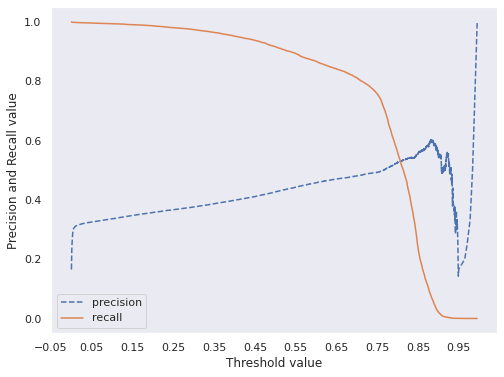

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, cb.predict_proba(X_test)[:,1])

## SHAP Value

In [57]:
!pip install shap

In [58]:
import shap
import skimage

In [59]:
explainer = shap.TreeExplainer(cb) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_train) # Shap Values 계산

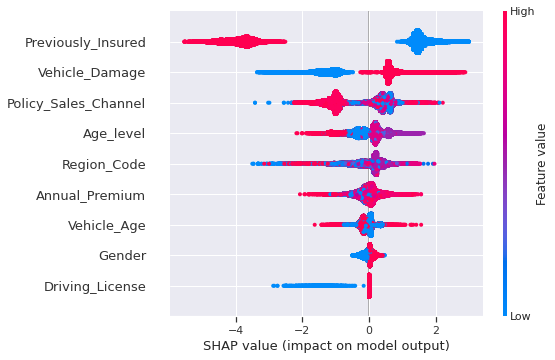

In [60]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

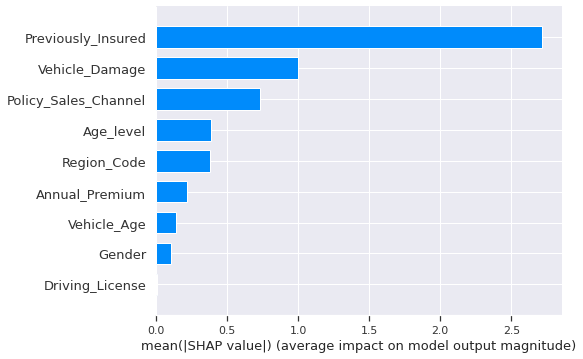

In [61]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type='bar')

## SHAP value

In [ ]:
!pip install pdpbox

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345b891cd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345bb4ed10>})

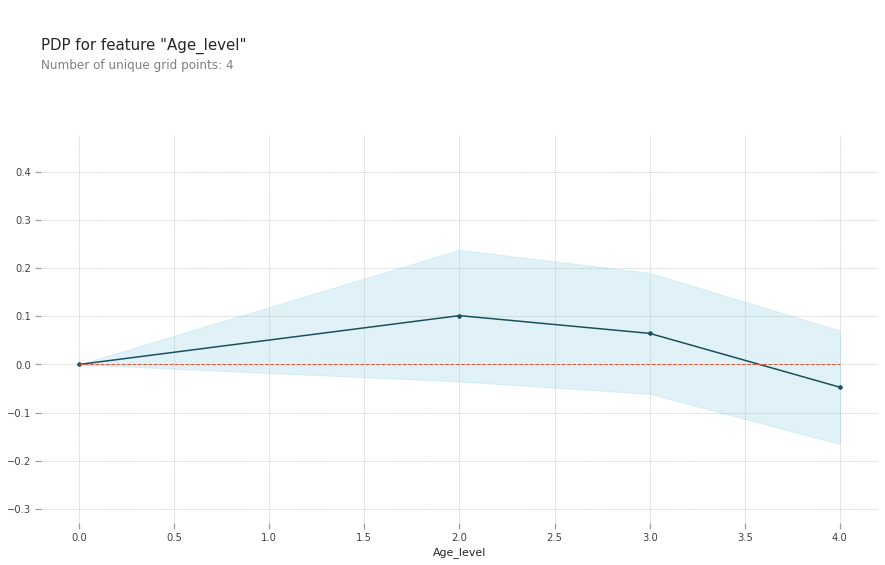

In [63]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Age_level'

isolated = pdp_isolate(
    model=cb, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345675a250>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345676d6d0>})

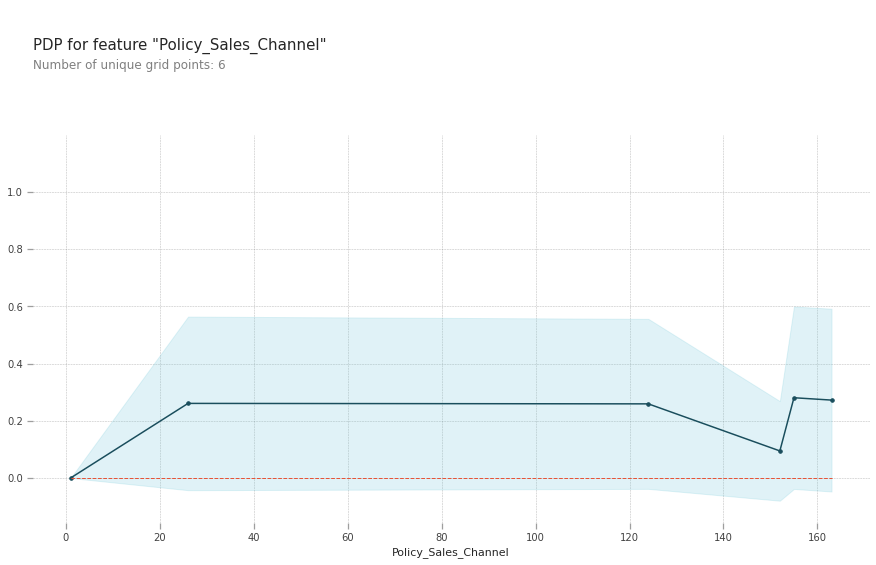

In [64]:
feature = 'Policy_Sales_Channel'

isolated = pdp_isolate(
    model=cb, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345c31acd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345c3200d0>})

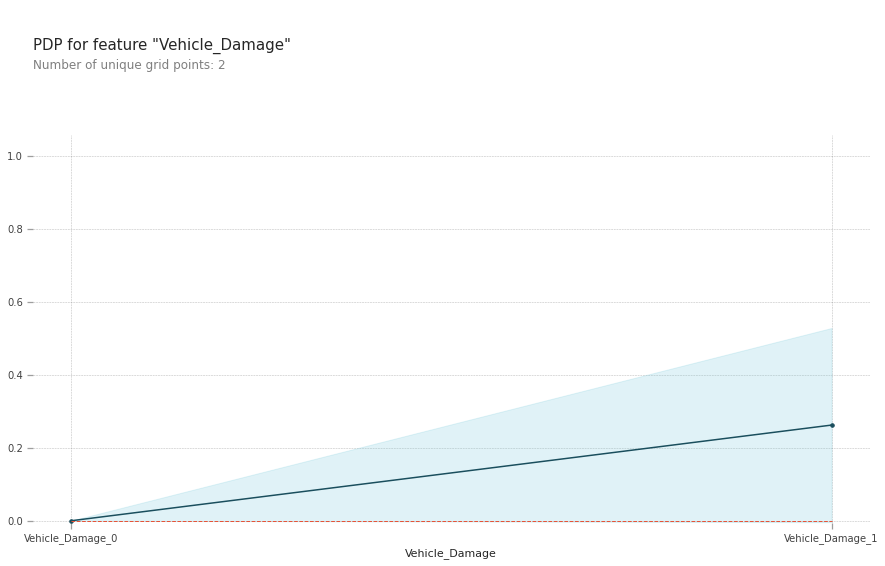

In [65]:
feature = 'Vehicle_Damage'

isolated = pdp_isolate(
    model=cb, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345c216310>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f345c231550>})

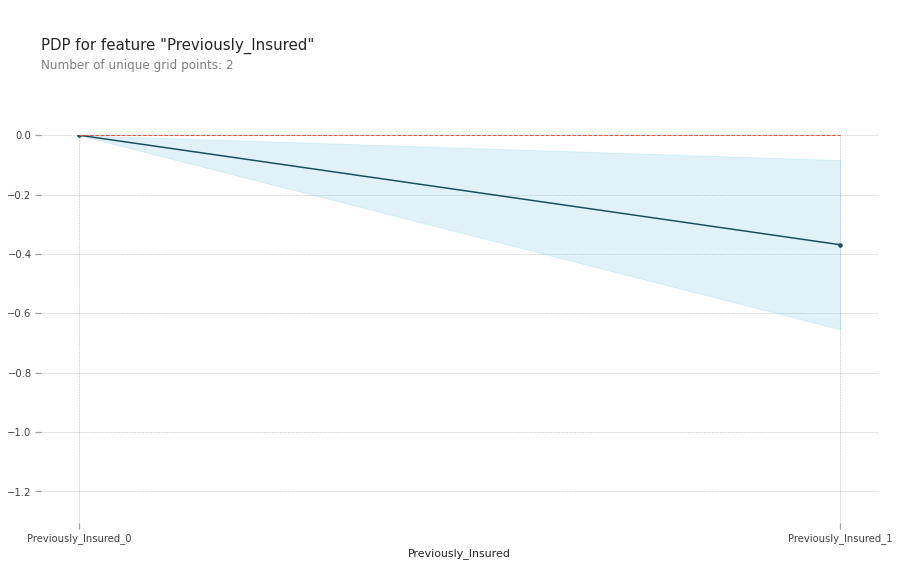

In [66]:
feature = 'Previously_Insured'

isolated = pdp_isolate(
    model=cb, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature)